<a href="https://colab.research.google.com/github/VarshiniAG/Lung-cancer-Detection-with-CNN-EfficientNetB3/blob/main/Lung_cancer_Detection_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lung cancer Detection with CNN | EfficientNetB3**

In [4]:
import os
import itertools

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3

# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
def loading_the_data(data_dir):
    # Generate data paths with labels
    filepaths = []
    labels = []

    # Get folder names
    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)

            filepaths.append(fpath)
            labels.append(fold)

    # Concatenate data paths with labels into one DataFrame
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')

    df = pd.concat([Fseries, Lseries], axis=1)

    return df


# change label names to its original names
def change_label_names(df, column_name):
    index = {'lung_aca': 'Lung_adenocarcinoma', 'lung_n': 'Lung_benign_tissue', 'lung_scc': 'Lung squamous_cell_carcinoma'}


    df[column_name] = df[column_name].replace(index)

In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/lung-and-colon-cancer-histopathological-images")

print("Path to dataset files:", path)

100%|██████████| 1.76G/1.76G [00:20<00:00, 93.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images/versions/1


In [7]:
data_dir = os.path.join(path, 'lung_colon_image_set/lung_image_sets')
df = loading_the_data(data_dir)

change_label_names(df, 'labels')
df

filepaths               labels
0      /root/.cache/kagglehub/datasets/andrewmvd/lung...  Lung_adenocarcinoma
1      /root/.cache/kagglehub/datasets/andrewmvd/lung...  Lung_adenocarcinoma
2      /root/.cache/kagglehub/datasets/andrewmvd/lung...  Lung_adenocarcinoma
3      /root/.cache/kagglehub/datasets/andrewmvd/lung...  Lung_adenocarcinoma
4      /root/.cache/kagglehub/datasets/andrewmvd/lung...  Lung_adenocarcinoma
...                                                  ...                  ...
14995  /root/.cache/kagglehub/datasets/andrewmvd/lung...   Lung_benign_tissue
14996  /root/.cache/kagglehub/datasets/andrewmvd/lung...   Lung_benign_tissue
14997  /root/.cache/kagglehub/datasets/andrewmvd/lung...   Lung_benign_tissue
14998  /root/.cache/kagglehub/datasets/andrewmvd/lung...   Lung_benign_tissue
14999  /root/.cache/kagglehub/datasets/andrewmvd/lung...   Lung_benign_tissue

[15000 rows x 2 columns]

**Data preprocessing**

first we will check if the training data is balanced or not

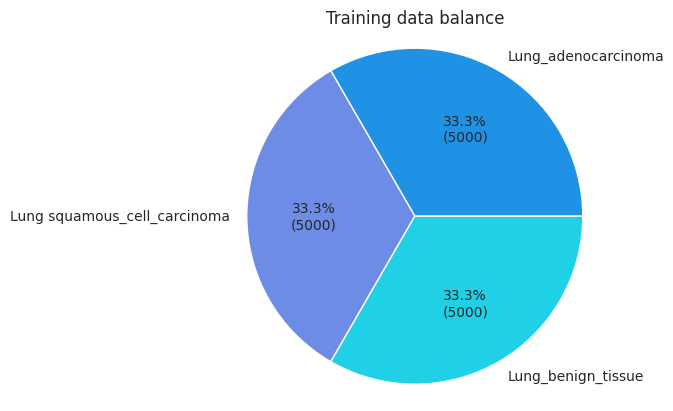

In [8]:
data_balance = df.labels.value_counts()


def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)


# pie chart for data balance
plt.pie(data_balance, labels = data_balance.index, autopct=custom_autopct, colors = ["#2092E6","#6D8CE6","#20D0E6"])
plt.title("Training data balance")
plt.axis("equal")
plt.show()

In [9]:
# data --> 80% train data && 20% (test, val)
train_df, ts_df = train_test_split(df, train_size = 0.8, shuffle = True, random_state = 42)

# test data --> 10% train data && 10% (test, val)
valid_df, test_df = train_test_split(ts_df, train_size = 0.5, shuffle = True, random_state = 42)

**Create image data generator**

in this step we will convert the whoole data to numpy arrays

In [10]:
batch_size = 32
img_size = (224, 224)

tr_gen = ImageDataGenerator(rescale=1. / 255)
ts_gen = ImageDataGenerator(rescale=1. / 255)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 12000 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.


***Display sample from train data***

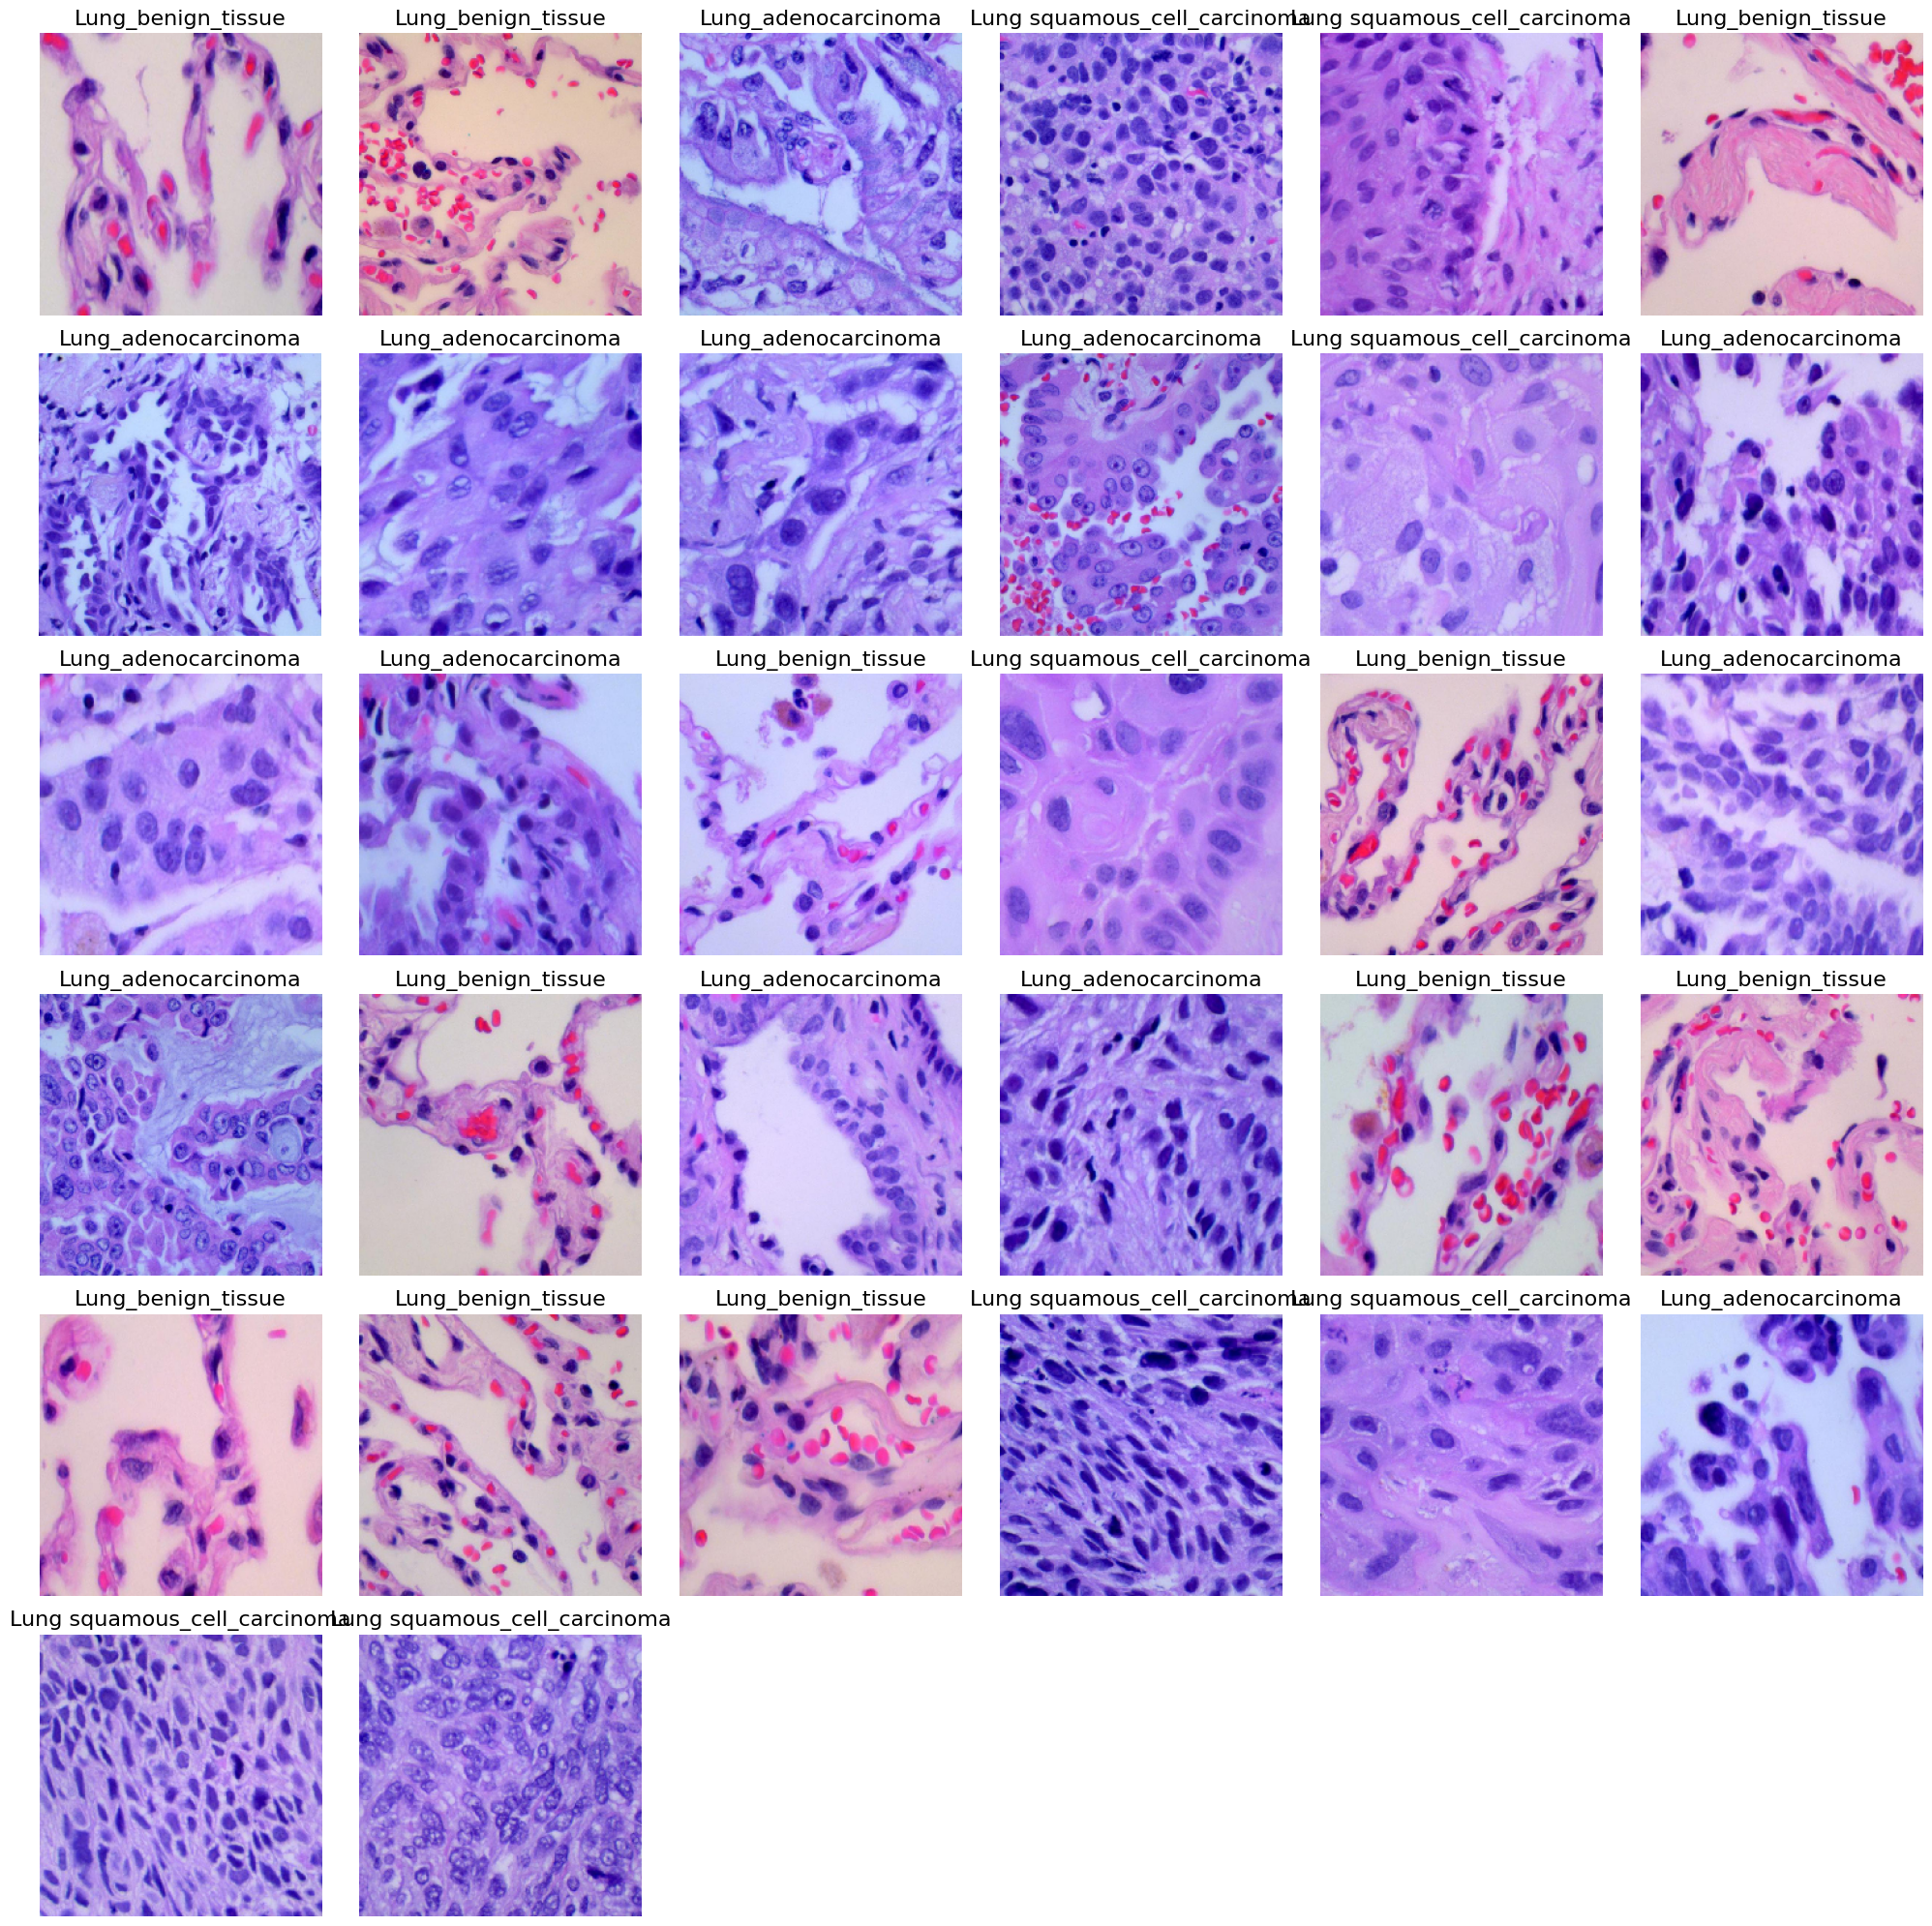

In [11]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

# ploting the patch size samples
plt.figure(figsize= (20, 20))

for i in range(batch_size):
    plt.subplot(6, 6, i + 1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'black', fontsize= 16)
    plt.axis('off')
plt.tight_layout()
plt.show()


**Create needed functions**

In [12]:
# Displaying the model performance
def model_performance(history, Epochs):
    # Define needed variables
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    Epochs = [i+1 for i in range(len(tr_acc))]

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()


# Evaluate the model
def model_evaluation(model):
    train_score = model.evaluate(train_gen, verbose= 1)
    valid_score = model.evaluate(valid_gen, verbose= 1)
    test_score = model.evaluate(test_gen, verbose= 1)

    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])


# Get Predictions
def get_pred(model, test_gen):

    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis = 1)

    return y_pred


# Confusion Matrix
def plot_confusion_matrix(test_gen, y_pred):

    g_dict = test_gen.class_indices
    classes = list(g_dict.keys())

    # Display the confusion matrix
    cm = confusion_matrix(test_gen.classes, y_pred)

    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')


    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.show()


# Defining a convolutional NN block for a sequential CNN model
def conv_block(filters, act='relu'):

    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPooling2D())

    return block


# Defining a dense NN block for a sequential CNN model
def dense_block(units, dropout_rate, act='relu'):

    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))

    return block

**Model Structure**

**CNN model**

In [13]:
# create Model structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_counts = len(list(train_gen.class_indices.keys()))     # to define number of classes in dense layer

In [14]:
# Model architecture
cnn_model = Sequential()

# first conv block
cnn_model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D())

# second conv block
cnn_model.add(conv_block(32))

# third conv block
cnn_model.add(conv_block(64))

# fourth conv bolck
cnn_model.add(conv_block(128))

# fifth conv block
cnn_model.add(conv_block(256))

# flatten layer
cnn_model.add(Flatten())

# first dense block
cnn_model.add(dense_block(128, 0.5))

# second dense block
cnn_model.add(dense_block(64, 0.3))

# third dense block
cnn_model.add(dense_block(32, 0.2))

# output layer
cnn_model.add(Dense(class_counts, activation = "softmax"))

In [15]:
cnn_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 56, 56, 32)     │        14,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 28, 28, 64)     │        55,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 14, 14, 128)    │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 7, 7, 256)      │       886,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 128)            │     1,606,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 64)             │         8,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_7 (Sequential)       │ (None, 32)             │         2,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,795,523 (10.66 MB)

 Trainable params: 2,794,083 (10.66 MB)

 Non-trainable params: 1,440 (5.62 KB)

In [16]:
# train the model
epochs = 5   # number of all epochs in training

history = cnn_model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 2167s 6s/step - accuracy: 0.7980 - loss: 0.5095 - val_accuracy: 0.3180 - val_loss: 4.1865
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 2211s 6s/step - accuracy: 0.9210 - loss: 0.2228 - val_accuracy: 0.9413 - val_loss: 0.1511
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 2147s 6s/step - accuracy: 0.9406 - loss: 0.1650 - val_accuracy: 0.9567 - val_loss: 0.1365
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 2166s 6s/step - accuracy: 0.9562 - loss: 0.1320 - val_accuracy: 0.9607 - val_loss: 0.1043
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 2143s 6s/step - accuracy: 0.9545 - loss: 0.1291 - val_accuracy: 0.9580 - val_loss: 0.1565


In [ ]:
Epoch 17/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 60s 161ms/step - accuracy: 0.9904 - loss: 0.0311 - val_accuracy: 0.9873 - val_loss: 0.0428
Epoch 18/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 62s 165ms/step - accuracy: 0.9890 - loss: 0.0350 - val_accuracy: 0.9800 - val_loss: 0.0559
Epoch 19/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 60s 161ms/step - accuracy: 0.9930 - loss: 0.0260 - val_accuracy: 0.9787 - val_loss: 0.0603
Epoch 20/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 59s 156ms/step - accuracy: 0.9878 - loss: 0.0367 - val_accuracy: 0.9467 - val_loss: 0.1745

**Display model performance**

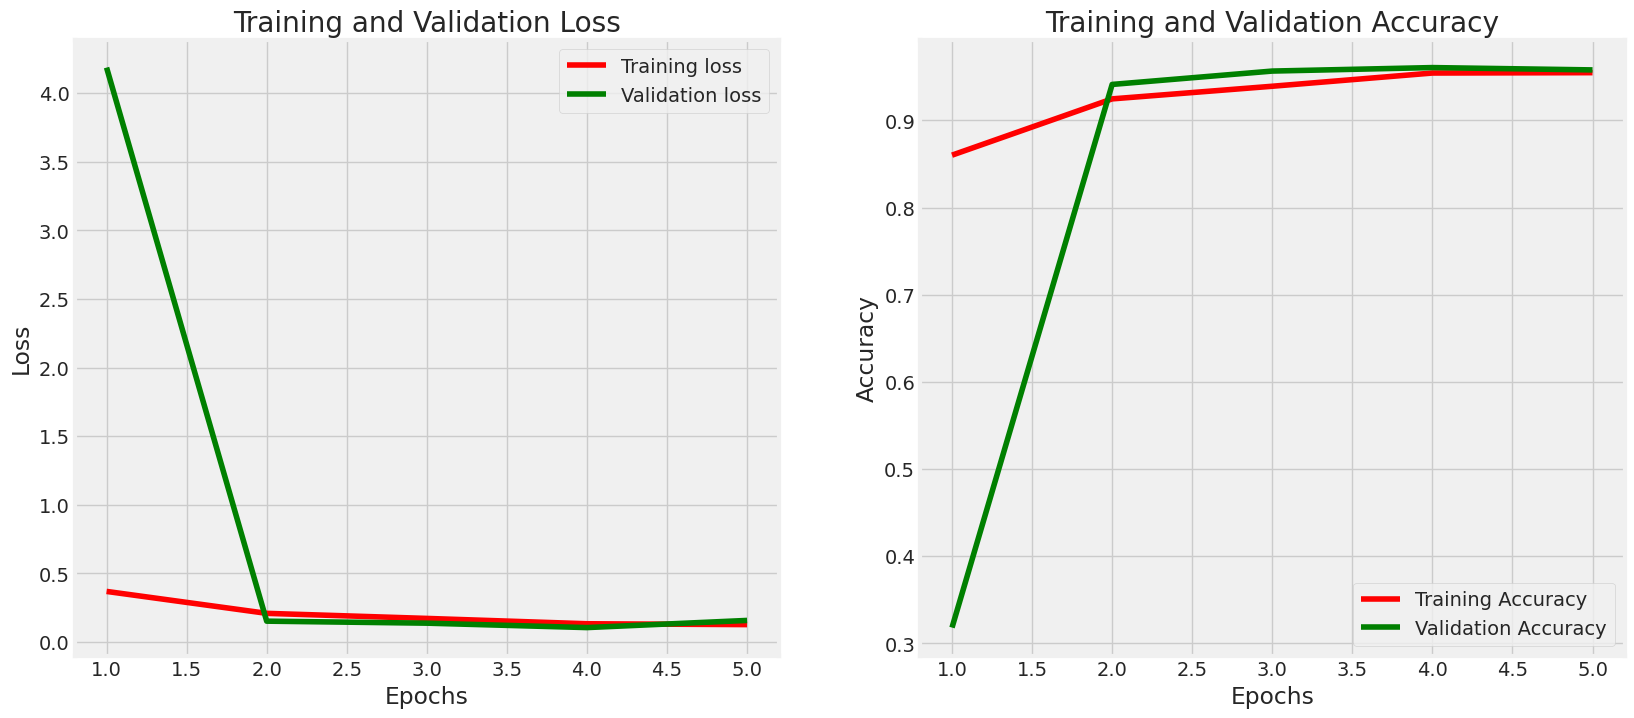

In [17]:
# Display model performance
model_performance(history, epochs)

**Evaluate the model**

In [18]:
# Model evaluation
model_evaluation(cnn_model)

375/375 ━━━━━━━━━━━━━━━━━━━━ 543s 1s/step - accuracy: 0.9560 - loss: 0.1464
47/47 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.9499 - loss: 0.1927
47/47 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9582 - loss: 0.1532
Train Loss:  0.1445079892873764
Train Accuracy:  0.9559999704360962
--------------------
Validation Loss:  0.15651339292526245
Validation Accuracy:  0.9580000042915344
--------------------
Test Loss:  0.1688944399356842
Test Accuracy:  0.9539999961853027


Get predictions and display the confusion matrix

47/47 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step


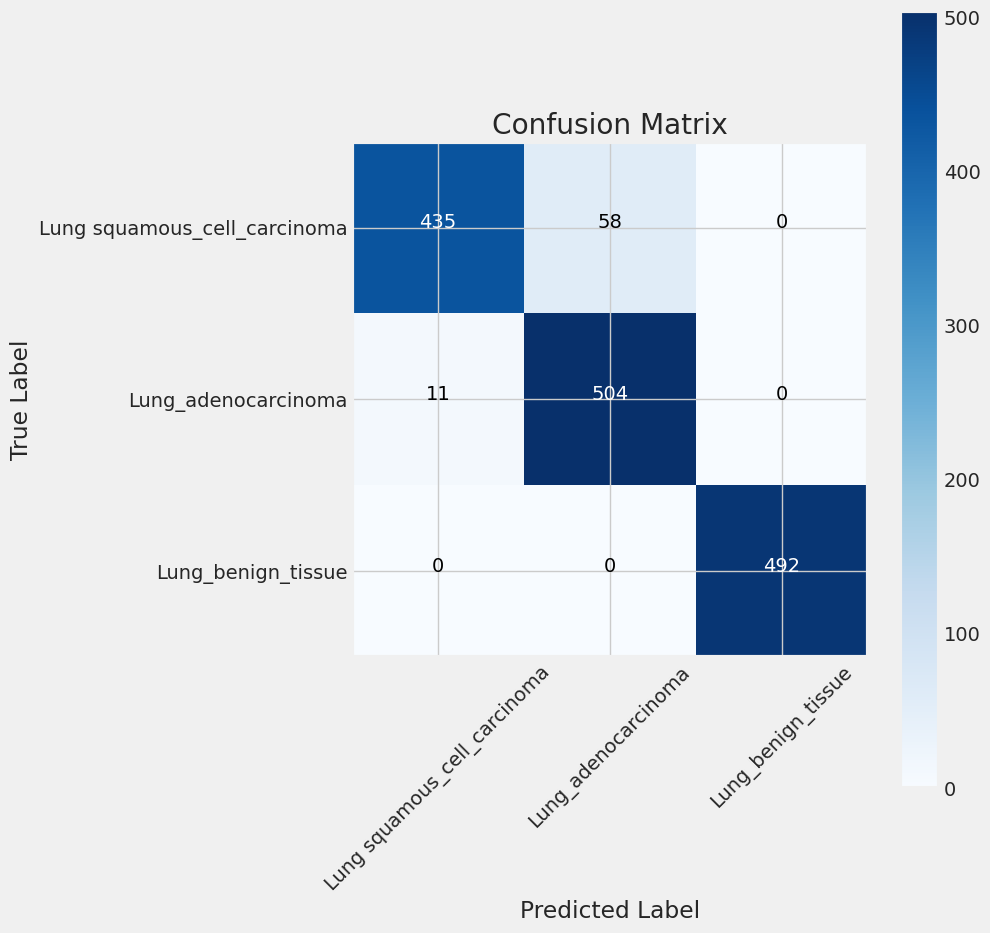

In [19]:
# get predictions
y_pred = get_pred(cnn_model, test_gen)

# plot the confusion matrix
plot_confusion_matrix(test_gen, y_pred)

# **EfficientNetB3**

In [20]:
from tensorflow.keras.applications import EfficientNetB3

# get the pre-trained model (EfficientNetB3)
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape = img_shape, pooling= None)

# fine-tune EfficientNetB3 (Adding some custom layers on top)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = dense_block(128, 0.5)(x)
x = dense_block(32, 0.2)(x)
predictions = Dense(class_counts, activation = "softmax")(x)    # output layer with softmax activation

# the model
EfficientNetB3_model = Model(inputs = base_model.input, outputs = predictions)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [21]:
EfficientNetB3_model.compile(optimizer=Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

EfficientNetB3_model.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_8[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        960 │ block1a_se_excit

 Total params: 10,991,282 (41.93 MB)

 Trainable params: 10,900,587 (41.58 MB)

 Non-trainable params: 90,695 (354.28 KB)

In [22]:
# train the model
epochs = 2   # number of all epochs in training

EfficientNetB3_history = EfficientNetB3_model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/2
375/375 ━━━━━━━━━━━━━━━━━━━━ 8011s 21s/step - accuracy: 0.6692 - loss: 0.7742 - val_accuracy: 0.3113 - val_loss: 1.3913
Epoch 2/2
375/375 ━━━━━━━━━━━━━━━━━━━━ 7867s 21s/step - accuracy: 0.9075 - loss: 0.2645 - val_accuracy: 0.9320 - val_loss: 0.1954


Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 103s 273ms/step - accuracy: 0.9633 - loss: 0.1315 - val_accuracy: 0.9920 - val_loss: 0.0490

Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 102s 272ms/step - accuracy: 0.9728 - loss: 0.1053 - val_accuracy: 0.9987 - val_loss: 0.0313

Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 102s 271ms/step - accuracy: 0.9836 - loss: 0.0764 - val_accuracy: 0.9987 - val_loss: 0.0205

Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 101s 270ms/step - accuracy: 0.9863 - loss: 0.0598 - val_accuracy: 0.9980 - val_loss: 0.0168

Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 102s 272ms/step - accuracy: 0.9866 - loss: 0.0568 - val_accuracy: 0.9987 - val_loss: 0.0119

Epoch 9/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 102s 271ms/step - accuracy: 0.9904 - loss: 0.0427 - val_accuracy: 1.0000 - val_loss: 0.0088

Epoch 10/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 102s 271ms/step - accuracy: 0.9937 - loss: 0.0355 - val_accuracy: 1.0000 - val_loss: 0.0080

Epoch 11/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 102s 273ms/step - accuracy: 0.9921 - loss: 0.0380 - val_accuracy: 1.0000 - val_loss: 0.0063

Epoch 12/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 101s 270ms/step - accuracy: 0.9961 - loss: 0.0272 - val_accuracy: 1.0000 - val_loss: 0.0051

Epoch 13/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 102s 271ms/step - accuracy: 0.9943 - loss: 0.0281 - val_accuracy: 1.0000 - val_loss: 0.0043

Epoch 14/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 102s 272ms/step - accuracy: 0.9963 - loss: 0.0213 - val_accuracy: 1.0000 - val_loss: 0.0040

Epoch 15/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 103s 273ms/step - accuracy: 0.9970 - loss: 0.0196 - val_accuracy: 1.0000 - val_loss: 0.0033

Epoch 16/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 102s 272ms/step - accuracy: 0.9962 - loss: 0.0200 - val_accuracy: 1.0000 - val_loss: 0.0027

Epoch 17/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 102s 271ms/step - accuracy: 0.9975 - loss: 0.0179 - val_accuracy: 1.0000 - val_loss: 0.0023

Epoch 18/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 103s 273ms/step - accuracy: 0.9981 - loss: 0.0148 - val_accuracy: 1.0000 - val_loss: 0.0019

Epoch 19/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 102s 272ms/step - accuracy: 0.9977 - loss: 0.0145 - val_accuracy: 1.0000 - val_loss: 0.0021

Epoch 20/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 142s 272ms/step - accuracy: 0.9983 - loss: 0.0126 - val_accuracy: 1.0000 - val_loss: 0.0018

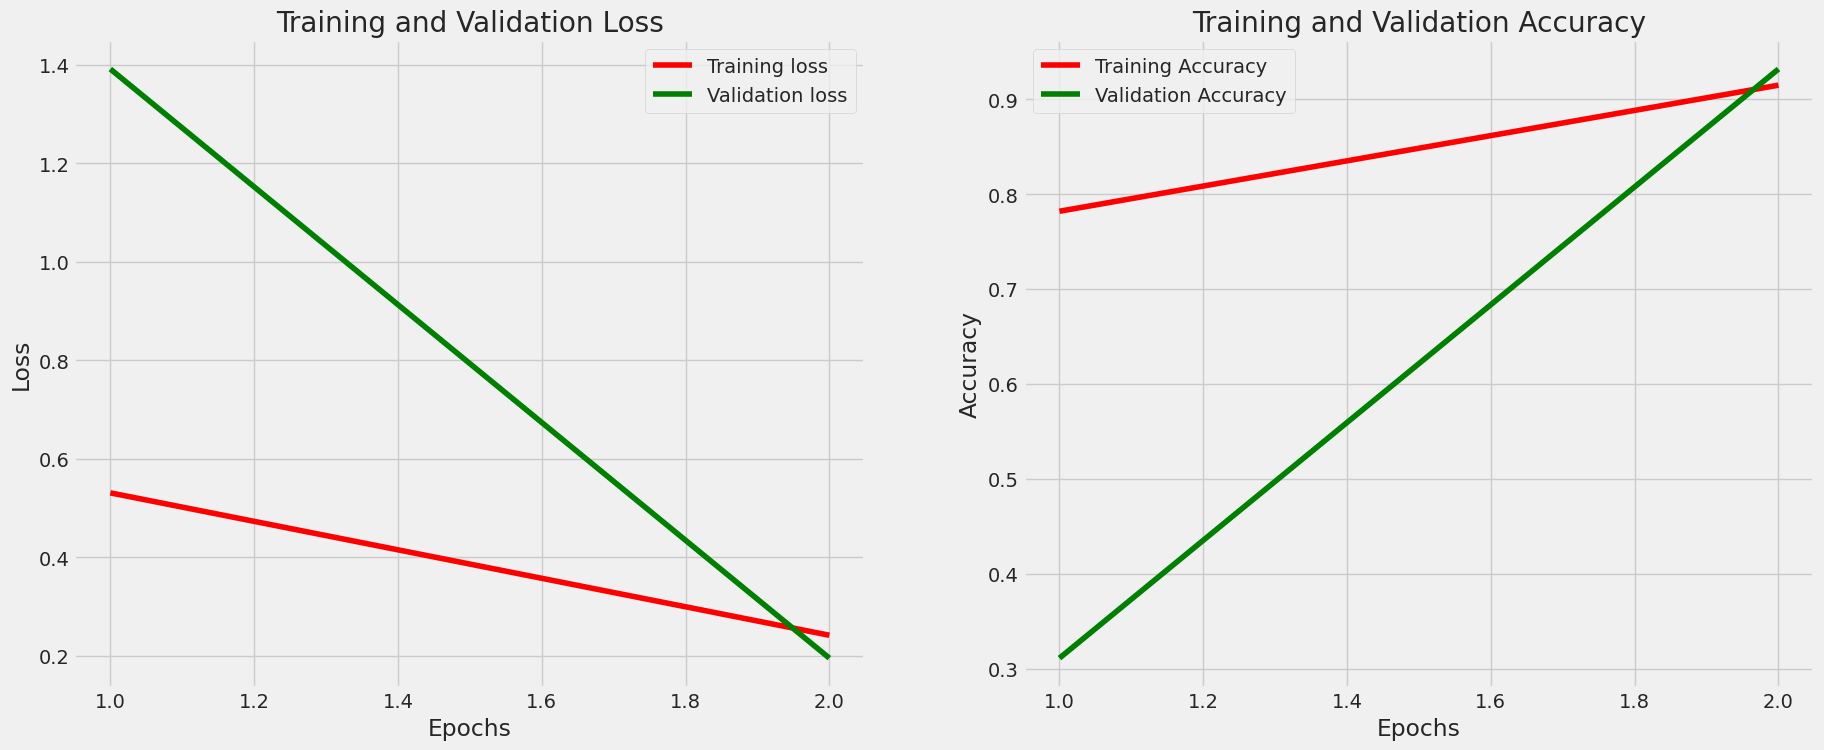

In [23]:
# Display model performance
model_performance(EfficientNetB3_history, epochs)



**Evaluate the model**

47/47 ━━━━━━━━━━━━━━━━━━━━ 219s 5s/step


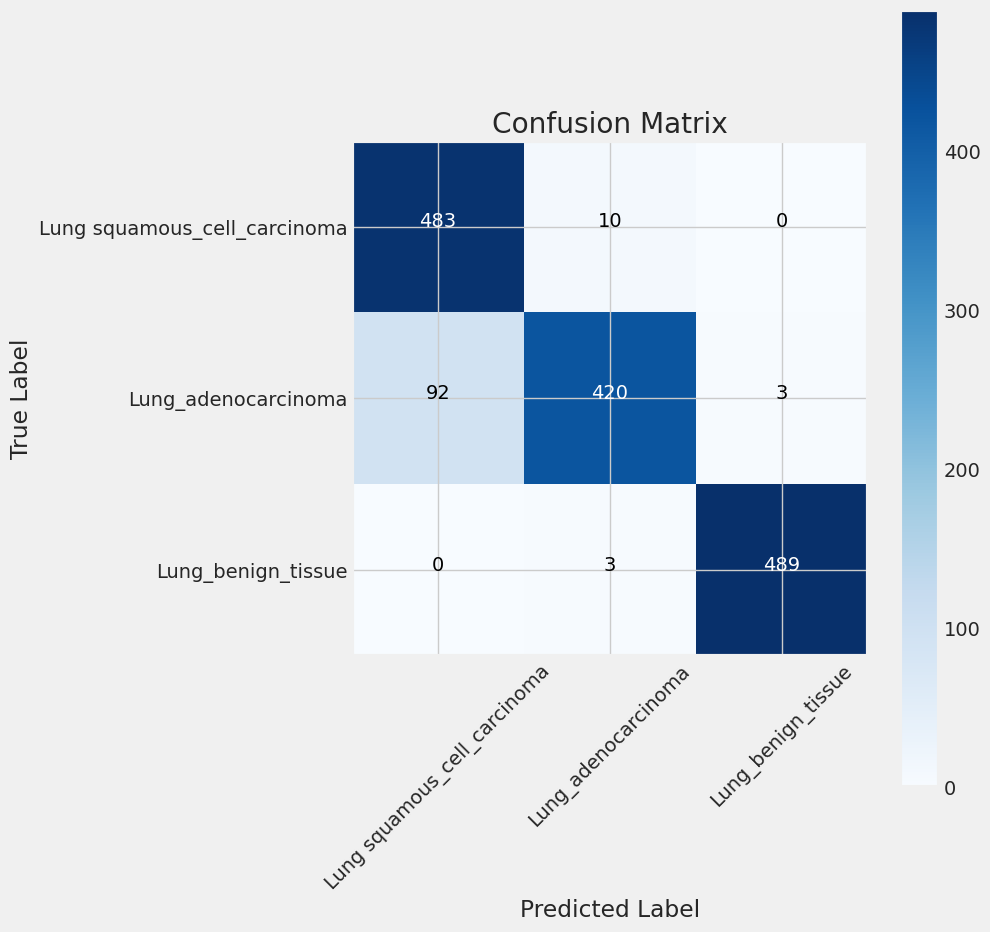

In [25]:
# get predictions
y_pred = get_pred(EfficientNetB3_model, test_gen)

# plot the confusion matrix
plot_confusion_matrix(test_gen, y_pred)

In [36]:
cnn_model.save("lung_model.h5")



In [37]:
from google.colab import files
files.download("lung_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
!pip install streamlit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 83.2 MB/s eta 0:00:00


In [39]:
import streamlit as st
import tensorflow as tf
import numpy as np
from PIL import Image

# -------------------------
# Load Model
# -------------------------
@st.cache_resource
def load_model():
    model = tf.keras.models.load_model("lung_model.h5")   # or change to .keras
    return model

model = load_model()

# Class names (modify if different)
CLASS_NAMES = ['Lung_adenocarcinoma', 'Lung_benign_tissue', 'Lung_squamous_cell_carcinoma']

# -------------------------
# Streamlit UI
# -------------------------
st.title("🫁 Lung Cancer Classification App")
st.write("Upload a lung histopathology image and the model will predict the cancer type.")

uploaded_file = st.file_uploader("Upload an image", type=["jpg", "jpeg", "png"])

# -------------------------
# Prediction Function
# -------------------------
def preprocess_image(image):
    img = image.resize((224, 224))
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    return img

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    st.image(image, caption="Uploaded Image", width=350)

    img_array = preprocess_image(image)
    prediction = model.predict(img_array)
    pred_class = CLASS_NAMES[np.argmax(prediction)]
    confidence = np.max(prediction) * 100

    st.subheader("Prediction")
    st.write(f"**Class:** {pred_class}")
    st.write(f"**Confidence:** {confidence:.2f}%")



2025-11-19 11:13:42.118 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-19 11:13:42.120 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-19 11:13:42.121 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-19 11:13:42.123 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-19 11:13:42.632 Thread 'Thread-7': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-19 11:13:42.657 Thread 'Thread-7': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-19 11:13:42.658 Thread 'Thread-7': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-19 11:13:42.829 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode

In [41]:
!pip install streamlit pyngrok


In [46]:
from pyngrok import ngrok

ngrok.set_auth_token("35h906bkkkIuVB6iOaFpVnMaBNd_2fFAyREPfGPaKFBBenq6V")


In [47]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
import numpy as np
from PIL import Image

@st.cache_resource
def load_model():
    model = tf.keras.models.load_model("lung_model.h5")
    return model

model = load_model()

CLASS_NAMES = ['Lung_adenocarcinoma', 'Lung_benign_tissue', 'Lung_squamous_cell_carcinoma']

st.title("🫁 Lung Cancer Classification App")
st.write("Upload a lung histopathology image to classify.")

uploaded_file = st.file_uploader("Upload an Image", type=["jpg", "jpeg", "png"])

def preprocess_image(image):
    img = image.resize((224, 224))
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    return img

if uploaded_file is not None:
    img = Image.open(uploaded_file)
    st.image(img, width=300)

    input_img = preprocess_image(img)
    preds = model.predict(input_img)
    pred_class = CLASS_NAMES[np.argmax(preds)]
    conf = float(np.max(preds)) * 100

    st.write("### Prediction:", pred_class)
    st.write(f"### Confidence: {conf:.2f}%")


Overwriting app.py


In [48]:
!streamlit run app.py &>/content/logs.txt &


In [49]:
public_url = ngrok.connect(8501)
public_url


<NgrokTunnel: "https://indiscerptible-traditionally-tori.ngrok-free.dev" -> "http://localhost:8501">